## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = 2 * np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 33 s, sys: 271 ms, total: 33.3 s
Wall time: 33.4 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.0005
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_4'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 50, weight_decay)
    )

Fold 1 started at Tue Jan 14 18:57:13 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


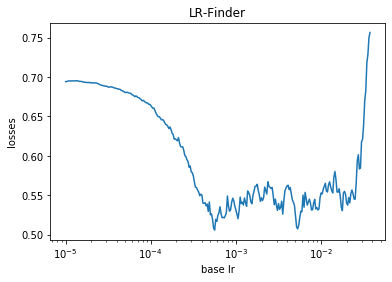

Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Fold 2 started at Tue Jan 14 18:58:55 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51768 - spearmanr 0.22494
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47135 - spearmanr 0.38903
best model: epoch 0 - 0.38903
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45692 - spearmanr 0.39241
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45814 - spearmanr 0.4152
best model: epoch 1 - 0.4152
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43273 - spearmanr 0.45719
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45302 - spearmanr 0.42313
best model: epoch 2 - 0.42313
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41397 - spearmanr 0.50463
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4556 - spearmanr 0.42239
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42313
Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Fold 3 started at Tue Jan 14 19:37:59 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51896 - spearmanr 0.22491
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.48189 - spearmanr 0.36321


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.36321
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4567 - spearmanr 0.39321
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45903 - spearmanr 0.40013
best model: epoch 1 - 0.40013
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43254 - spearmanr 0.45934
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46066 - spearmanr 0.40158
best model: epoch 2 - 0.40158
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41398 - spearmanr 0.50575
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46148 - spearmanr 0.401
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40158
Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Fold 4 started at Tue Jan 14 20:17:28 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51719 - spearmanr 0.22842
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47181 - spearmanr 0.37063
best model: epoch 0 - 0.37063
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45579 - spearmanr 0.39803
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45681 - spearmanr 0.39427
best model: epoch 1 - 0.39427
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43207 - spearmanr 0.46066
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45415 - spearmanr 0.39711
best model: epoch 2 - 0.39711
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41322 - spearmanr 0.50925
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45681 - spearmanr 0.40049
best model: epoch 3 - 0.40049
TRAINING END: Best score achieved on epoch 3 - 0.40049
Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Fold 5 started at Tue Jan 14 20:56:47 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51933 - spearmanr 0.22323
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46657 - spearmanr 0.36802
best model: epoch 0 - 0.36802
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45709 - spearmanr 0.39471
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45511 - spearmanr 0.39866
best model: epoch 1 - 0.39866
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.433 - spearmanr 0.4606
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4483 - spearmanr 0.40796
best model: epoch 2 - 0.40796
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4138 - spearmanr 0.50778
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45284 - spearmanr 0.40632
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40796
Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Fold 6 started at Tue Jan 14 21:36:39 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51782 - spearmanr 0.22643
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46492 - spearmanr 0.36503
best model: epoch 0 - 0.36503
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45642 - spearmanr 0.39821
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4517 - spearmanr 0.39354
best model: epoch 1 - 0.39354
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43317 - spearmanr 0.46011
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44879 - spearmanr 0.39847
best model: epoch 2 - 0.39847
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41411 - spearmanr 0.50771
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45174 - spearmanr 0.39836
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39847
Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Fold 7 started at Tue Jan 14 22:16:12 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51731 - spearmanr 0.22648
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47157 - spearmanr 0.37568
best model: epoch 0 - 0.37568
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45598 - spearmanr 0.39615
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45934 - spearmanr 0.40884
best model: epoch 1 - 0.40884
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43244 - spearmanr 0.45873
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45601 - spearmanr 0.41422
best model: epoch 2 - 0.41422
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41386 - spearmanr 0.50577
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45914 - spearmanr 0.41475
best model: epoch 3 - 0.41475
TRAINING END: Best score achieved on epoch 3 - 0.41475
Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Fold 8 started at Tue Jan 14 22:55:28 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51723 - spearmanr 0.22672
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47208 - spearmanr 0.38816
best model: epoch 0 - 0.38816
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45604 - spearmanr 0.39481
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4598 - spearmanr 0.40945
best model: epoch 1 - 0.40945
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43214 - spearmanr 0.45889
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4591 - spearmanr 0.41756
best model: epoch 2 - 0.41756
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41342 - spearmanr 0.50624
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46303 - spearmanr 0.4179
best model: epoch 3 - 0.4179
TRAINING END: Best score achieved on epoch 3 - 0.41790
Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Fold 9 started at Tue Jan 14 23:35:13 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.52029 - spearmanr 0.22209
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47289 - spearmanr 0.36807
best model: epoch 0 - 0.36807
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45668 - spearmanr 0.39547
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4585 - spearmanr 0.39674
best model: epoch 1 - 0.39674
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43285 - spearmanr 0.45863
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45408 - spearmanr 0.40264
best model: epoch 2 - 0.40264
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41407 - spearmanr 0.50652
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45653 - spearmanr 0.40444
best model: epoch 3 - 0.40444
TRAINING END: Best score achieved on epoch 3 - 0.40444
Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Fold 10 started at Wed Jan 15 00:14:15 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51785 - spearmanr 0.22908
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46405 - spearmanr 0.38393
best model: epoch 0 - 0.38393
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45695 - spearmanr 0.39431
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44652 - spearmanr 0.42483
best model: epoch 1 - 0.42483
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43359 - spearmanr 0.45882
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44335 - spearmanr 0.42457
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41487 - spearmanr 0.50486
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4456 - spearmanr 0.424
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42483
Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



OOF score: 0.40970285689031116


In [12]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese with smoothing (1): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese with token_type_ids (2): 0.4091. 0.4236. 0.4317, 0.4507
    #bert siamese for 3 epochs (3): 0.4121. 0.4273. 0.4347, 0.4497
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [13]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

def ahmet_round(preds, ds, indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

In [14]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.3472315542183132
0 10 0.37454667889902826
0 15 0.3769718074710197
0 20 0.3788017031582827
0 33 0.38051321904938523
0 None 0.3808501274181663
1 5 0.6468460438126423
1 10 0.6570718191809423
1 15 0.6575396596693883
1 20 0.6590495264086262
1 33 0.6593919459100619
1 None 0.6599293631911697
2 5 0.4820291445304191
3 5 0.2876687227522288
3 10 0.30522166844432624
3 15 0.3068152696691316
3 20 0.3077153760341711
3 33 0.3107929785524903
4 5 0.3460156927742489
4 10 0.34903659678491283
4 15 0.3499595435281085
4 33 0.3506691728427852
4 None 0.3509446958625731
5 5 0.4502175639724634
6 5 0.3307859775816452
6 10 0.35244979019305345
6 15 0.3591196083458648
7 5 0.5019177596534042
7 10 0.5105994448648933
8 5 0.5751885021588062
8 10 0.5763256163926463
9 10 0.0669897961844408
9 20 0.13039964000791623
10 5 0.45237103240382825
10 10 0.4615673552149848
10 15 0.4617138550248038
10 20 0.46357985144096653
11 5 0.7512457678740239
11 10 0.7526327438335784
12 5 0.5116237097960404
13 5 0.1420761857240988
13 10 0

In [15]:
opt_ds, opt_indices

([5,
  33,
  5,
  15,
  10,
  10,
  20,
  20,
  10,
  5,
  10,
  10,
  5,
  15,
  20,
  33,
  20,
  15,
  33,
  20,
  20],
 [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 25, 26, 29])

In [16]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.44383784850734603

In [17]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.44383784850734603

In [18]:
spearmanr_np(oofs, y)

0.40970285689031116

In [19]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.4246026823688233

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.841377,0.774595,0.421821,0.551116,0.549339,0.455888,0.684610,0.649643,0.549969,0.004707,0.663295,0.759831,0.019720,0.266340,0.007576,0.016067,0.063063,0.128931,0.775320,0.000943,0.861045,0.492832,0.179563,0.624791,0.621560,0.279879,0.039975,0.051805,0.632225,0.542765
1,46,0.572401,0.583952,0.023278,0.750275,0.610440,0.851316,0.442173,0.371286,0.028256,0.028275,0.460692,0.130718,0.005650,0.001292,0.001272,0.016927,0.862188,0.284219,0.071599,0.000366,0.319003,0.781829,0.519573,0.871876,0.929328,0.679396,0.938628,0.180299,0.028508,0.564435
2,70,0.710644,0.633529,0.056078,0.682442,0.764300,0.907898,0.516741,0.383972,0.268676,0.009110,0.347002,0.729696,0.024448,0.049734,0.003647,0.011371,0.261478,0.145619,0.605673,0.001714,0.665872,0.598398,0.282248,0.770726,0.761685,0.434814,0.103060,0.067395,0.659764,0.551531
3,132,0.598985,0.359490,0.017432,0.638701,0.604152,0.853846,0.388690,0.254752,0.158485,0.018046,0.596075,0.203899,0.007002,0.004939,0.001568,0.006732,0.825454,0.332570,0.407858,0.000485,0.429535,0.780783,0.584229,0.861172,0.899945,0.641682,0.853991,0.329403,0.480208,0.607655
4,200,0.805064,0.498612,0.085642,0.839243,0.669204,0.835188,0.669601,0.688064,0.112819,0.040299,0.382614,0.449269,0.013794,0.025779,0.014011,0.078133,0.175275,0.171887,0.537200,0.005944,0.455189,0.685777,0.498278,0.823123,0.829403,0.592172,0.206154,0.188033,0.624895,0.546277


In [22]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [23]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.830340,0.658740,0.368422,0.575321,0.434350,0.260140,0.615068,0.547434,0.366757,0.003705,0.797815,0.453269,0.500825,0.056931,0.009860,0.216490,0.105197,0.074750,0.599586,0.001705,0.833737,0.866895,0.608858,0.943352,0.920505,0.671961,0.122252,0.102199,0.917206,0.759656
1,0.902389,0.793698,0.029060,0.533516,0.954915,0.676849,0.501271,0.615754,0.242963,0.001079,0.267555,0.068239,0.914469,0.003267,0.501643,0.035874,0.033952,0.032706,0.293427,0.002598,0.811319,0.496745,0.244218,0.695356,0.750346,0.279138,0.014152,0.021494,0.534241,0.787617
2,0.644344,0.170343,0.006063,0.782406,0.756659,0.864816,0.524290,0.318536,0.187563,0.001036,0.406233,0.359669,0.004251,0.002685,0.000307,0.331704,0.665985,0.169158,0.117139,0.000063,0.622214,0.872267,0.563157,0.908992,0.899898,0.703825,0.582093,0.182055,0.374856,0.767189
3,0.669019,0.594427,0.194568,0.753622,0.753214,0.837820,0.579183,0.566650,0.353845,0.002355,0.316396,0.955088,0.021430,0.041676,0.022181,0.028388,0.060051,0.198579,0.499080,0.001786,0.839226,0.760435,0.690205,0.777083,0.847181,0.715159,0.099488,0.249115,0.839037,0.711774
4,0.836756,0.770530,0.003433,0.703380,0.806094,0.914055,0.472321,0.447886,0.200273,0.001208,0.295760,0.666050,0.002665,0.000818,0.001786,0.006453,0.861836,0.246053,0.110866,0.000049,0.792061,0.771895,0.427982,0.825077,0.857753,0.587816,0.917645,0.229758,0.036444,0.580388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.830224,0.290117,0.239374,0.853649,0.632482,0.656871,0.699226,0.678731,0.470433,0.003893,0.535273,0.915516,0.174379,0.142520,0.009196,0.228566,0.017217,0.036295,0.538032,0.002504,0.690492,0.798935,0.691294,0.894962,0.895545,0.673359,0.076620,0.066643,0.884919,0.733776
6075,0.927624,0.472153,0.122953,0.609460,0.448168,0.278469,0.819406,0.828325,0.029398,0.005085,0.820067,0.010052,0.005117,0.007923,0.000262,0.009292,0.763513,0.315942,0.164403,0.000079,0.803846,0.820873,0.617345,0.897451,0.943338,0.632853,0.762173,0.310517,0.352863,0.890833
6076,0.559794,0.334170,0.014447,0.628113,0.669679,0.856098,0.418200,0.326990,0.338180,0.004560,0.578361,0.506254,0.006734,0.007039,0.003205,0.008415,0.839909,0.386464,0.249478,0.000552,0.363778,0.546199,0.274932,0.750018,0.706454,0.304906,0.574034,0.249897,0.410974,0.358246
6077,0.787469,0.515848,0.674378,0.202374,0.217064,0.088857,0.631332,0.770081,0.910177,0.001406,0.930865,0.707791,0.113529,0.147152,0.008444,0.038513,0.058732,0.331973,0.705252,0.000416,0.891826,0.659388,0.454465,0.814549,0.833530,0.458963,0.022129,0.138518,0.860541,0.832519


In [24]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.380850
question_body_critical                   0.659929
question_conversational                  0.410601
question_expect_short_answer             0.310227
question_fact_seeking                    0.350945
question_has_commonly_accepted_answer    0.427704
question_interestingness_others          0.358812
question_interestingness_self            0.510118
question_multi_intent                    0.575021
question_not_really_a_question           0.090849
question_opinion_seeking                 0.463307
question_type_choice                     0.738147
question_type_compare                    0.359312
question_type_consequence                0.182278
question_type_definition                 0.358243
question_type_entity                     0.447398
question_type_instructions               0.780337
question_type_procedure                  0.360677
question_type_reason_explanation         0.667984
question_type_spelling                   0.065094


In [25]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.065094,3.0
question_not_really_a_question,0.090849,5.0
answer_plausible,0.139242,9.0
answer_relevance,0.169652,9.0
question_type_consequence,0.182278,5.0
answer_well_written,0.217619,9.0
answer_helpful,0.236961,9.0
answer_type_procedure,0.302735,5.0
question_expect_short_answer,0.310227,5.0
answer_satisfaction,0.328652,17.0


In [26]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

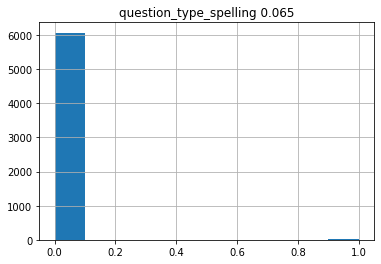

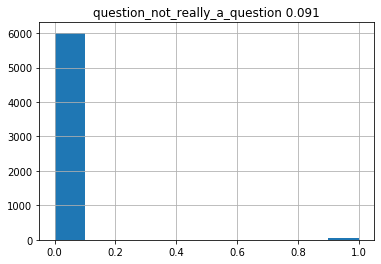

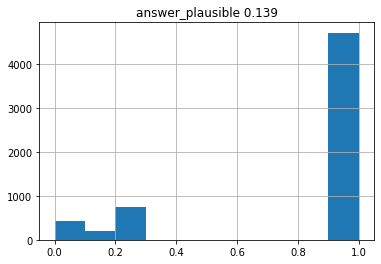

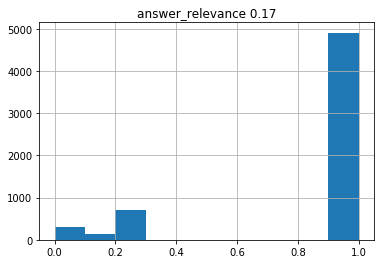

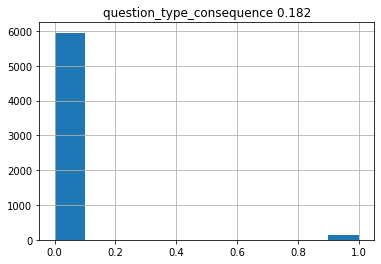

In [27]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


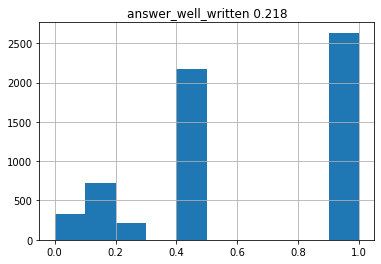

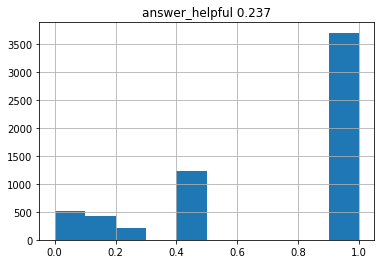

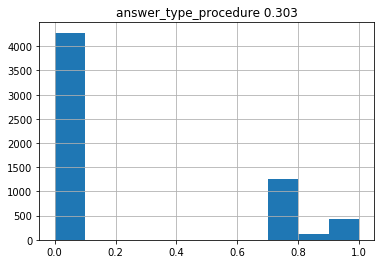

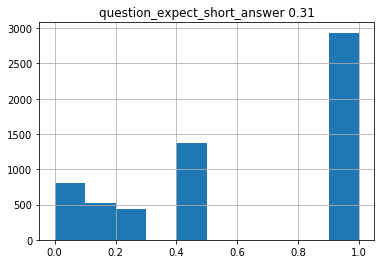

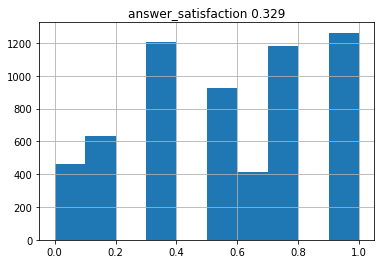

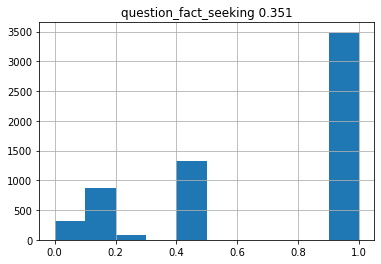

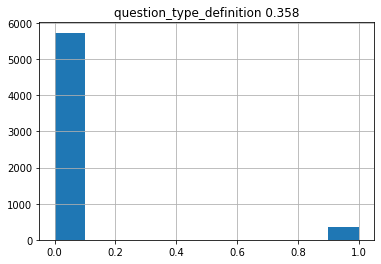

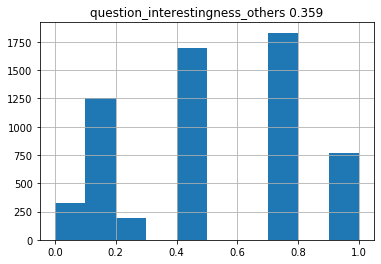

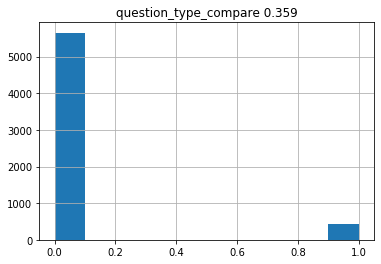

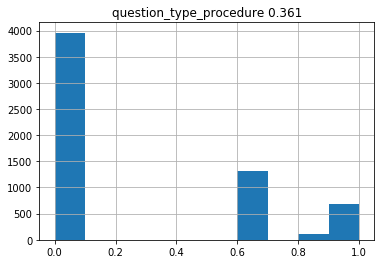

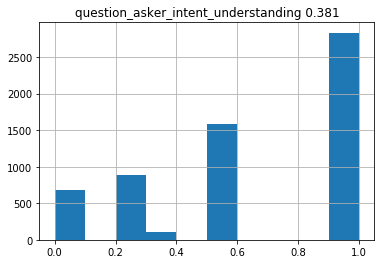

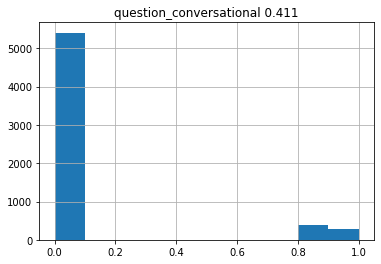

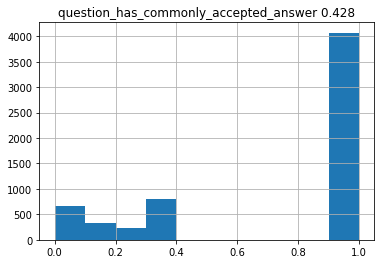

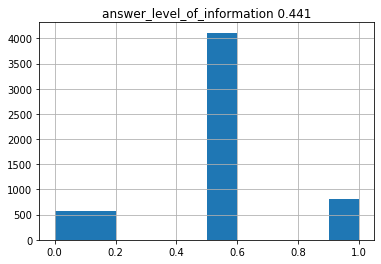

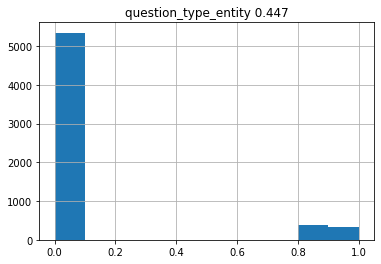

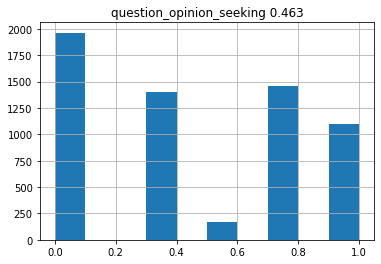

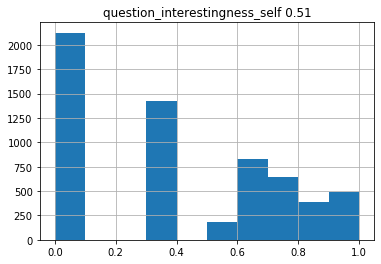

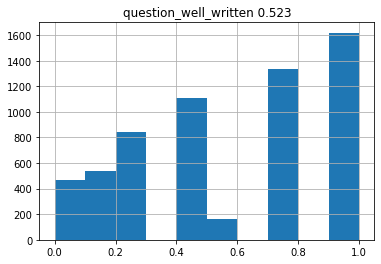

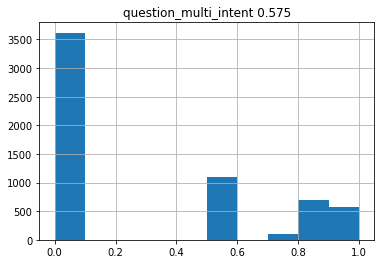

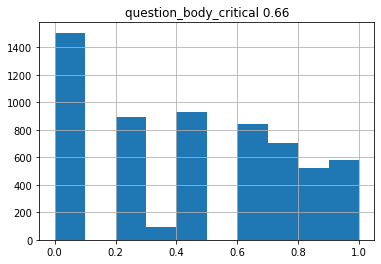

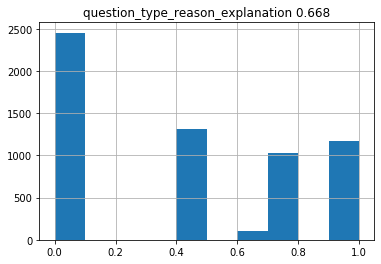

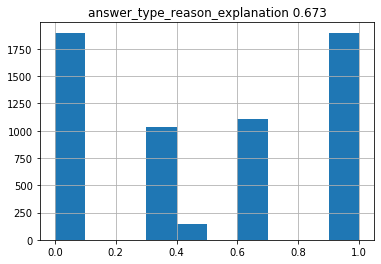

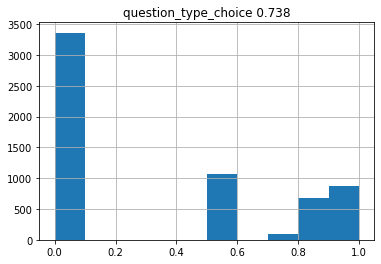

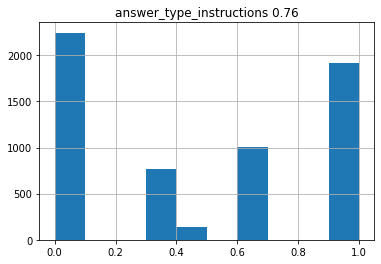

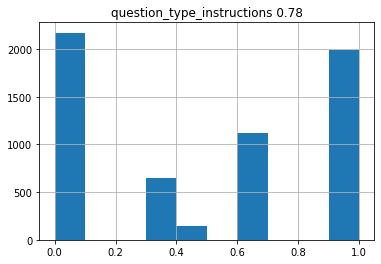

In [28]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')